# REINFORCE, w/ and w/o Baseline, w/ and w/o temporal structure

---

In this notebook, we will train the agent with OpenAI Gym's Cartpole environment.

### Import Packages

In [11]:
import gym
import gym.wrappers as wrappers
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### Network Architecture

In [2]:
env = gym.make('CartPole-v0')
# env = gym.make('Pendulum-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
    
class Value(nn.Module):
    def __init__(self, s_size=4, h_size=16, out_size=1):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, out_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def v_f(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        value = self.forward(state).cpu()
        return value[0]

observation space: Box(4,)
action space: Discrete(2)


### REINFORCE agent with temporal structure and (NN)Baseline selection options

In [3]:
def reinforce_nn(ts=True, baseline=True, n_episodes=2000, max_t=1000, gamma=0.99, print_every=100):
    
    policy = Policy().to(device)
    value = Value(h_size=10).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)
    optimizer_value = optim.Adam(value.parameters(), lr=1e-1)

    l2loss = nn.MSELoss() # Define the loss for value function
    
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        value_state = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            value_state.append(value.v_f(state))
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        R_temp = np.cumsum([a*b for a,b in zip(discounts, rewards)])
        
        # This G is actually G(t)*gamma^t
        G = R - np.insert(R_temp[0:len(rewards)-1],0,0)
        if (not ts): # Without temporal structure, G(t) is replaced by R(\tau) 
            G = R * np.ones(len(rewards))
                        
        policy_loss = []
        value_loss = []
        t=0
        for log_prob in saved_log_probs:
            baseline = value_state[t].detach().numpy()
            if baseline:
                policy_loss.append(-log_prob * (G[t] - (gamma**t)*baseline[0]))
            else:
                policy_loss.append(-log_prob * (G[t]))
            t+=1
        
        if baseline:
            t=0
            for vs in value_state:
                G_ = torch.from_numpy(np.array(G[t])).float().to(device)
                # V(s_t) can be trained with G_t
                value_loss.append(l2loss(vs,G_/(gamma**t)))
                t+=1
            value_loss = torch.stack(value_loss).sum()
        
        policy_loss = torch.cat(policy_loss).sum()        
        
        # Pytorch NN houdini step!
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        optimizer_value.zero_grad()
        value_loss.backward()
        optimizer_value.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break # Stops training, since we have reached the (as per Gym) optimal!
        
    return scores, policy
    


### REINFORCE agent with temporal structure selection option and (V_pi*)Baseline

In [4]:
def reinforce(ts=True, policy_opt_wobaseline=Policy(h_size=30).to(device), n_episodes=2000, max_t=1000, gamma=0.99, print_every=100):
    policy = Policy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=5e-3)
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state_collect = []
        state = env.reset()
        for t in range(max_t):
            state_collect.append(state)
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        R_temp = np.cumsum([a*b for a,b in zip(discounts, rewards)])
        
        G = R - np.insert(R_temp[0:len(rewards)-1],0,0)
        if (not ts):
            G = R * np.ones(len(rewards))
            
        policy_loss = []
        t=0
        for log_prob in saved_log_probs:
            total_dr = []
            s=state_collect[t]
            for t1 in range(max_t):
                a, temp = policy_opt_wobaseline.act(s)
                s, r, d, _ = env.step(a)
                total_dr.append((gamma**t1)*r)
                if d:
                    break
            baseline = sum(total_dr)
            policy_loss.append(-log_prob * (G[t] - (gamma**t)*baseline))
            t+=1
            
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break # Stops training
        
    return scores
    


In [5]:
sims = 5

# Classic REINFORCE
for i in range(sims):
    scores, policy_opt_wobaseline = reinforce_nn(baseline=False)
    scores = np.array(scores)
    if i==0:
        avg_scores=scores
    else:
        common_len = min(len(scores),len(avg_scores))
        select = np.argmin(np.array([len(scores),len(avg_scores)]))
        avg_scores[0:common_len]+=(scores[0:common_len]-avg_scores[0:common_len])/i
        if select == 1:
            avg_scores=np.append(avg_scores,scores[common_len:len(scores)])
scores_classic = avg_scores
policy = policy_opt_wobaseline

# REINFORCE with NN baseline
for i in range(sims):
    scores, _ = reinforce_nn()
    scores = np.array(scores)
    if i==0:
        avg_scores=scores
    else:
        common_len = min(len(scores),len(avg_scores))
        select = np.argmin(np.array([len(scores),len(avg_scores)]))
        avg_scores[0:common_len]+=(scores[0:common_len]-avg_scores[0:common_len])/i
        if select == 1:
            avg_scores=np.append(avg_scores,scores[common_len:len(scores)])
scores_nnbaseline = avg_scores

# REINFORCE with V_pi* baseline
for i in range(sims):
    scores = reinforce(policy_opt_wobaseline=policy_opt_wobaseline)
    scores = np.array(scores)
    if i==0:
        avg_scores=scores
    else:
        common_len = min(len(scores),len(avg_scores))
        select = np.argmin(np.array([len(scores),len(avg_scores)]))
        avg_scores[0:common_len]+=(scores[0:common_len]-avg_scores[0:common_len])/i
        if select == 1:
            avg_scores=np.append(avg_scores,scores[common_len:len(scores)])
scores_pioptbaseline = avg_scores

################## W/O Temporal structure ###################

# Classic REINFORCE
for i in range(sims):
    scores, policy_opt_wobaseline = reinforce_nn(ts=False,baseline=False)
    scores = np.array(scores)
    if i==0:
        avg_scores=scores
    else:
        common_len = min(len(scores),len(avg_scores))
        select = np.argmin(np.array([len(scores),len(avg_scores)]))
        avg_scores[0:common_len]+=(scores[0:common_len]-avg_scores[0:common_len])/i
        if select == 1:
            avg_scores=np.append(avg_scores,scores[common_len:len(scores)])
scores_wots = avg_scores

# REINFORCE with NN baseline
for i in range(sims):
    scores, _ = reinforce_nn(ts=False)
    scores = np.array(scores)
    if i==0:
        avg_scores=scores
    else:
        common_len = min(len(scores),len(avg_scores))
        select = np.argmin(np.array([len(scores),len(avg_scores)]))
        avg_scores[0:common_len]+=(scores[0:common_len]-avg_scores[0:common_len])/i
        if select == 1:
            avg_scores=np.append(avg_scores,scores[common_len:len(scores)])
scores_wots_nnbaseline = avg_scores

# REINFORCE with V_pi* baseline
for i in range(sims):
    scores = reinforce(ts=False,policy_opt_wobaseline=policy_opt_wobaseline)
    scores = np.array(scores)
    if i==0:
        avg_scores=scores
    else:
        common_len = min(len(scores),len(avg_scores))
        select = np.argmin(np.array([len(scores),len(avg_scores)]))
        avg_scores[0:common_len]+=(scores[0:common_len]-avg_scores[0:common_len])/i
        if select == 1:
            avg_scores=np.append(avg_scores,scores[common_len:len(scores)])
scores_wots_pioptbaseline = avg_scores



Episode 100	Average Score: 41.36
Episode 200	Average Score: 172.36
Episode 300	Average Score: 193.05
Environment solved in 251 episodes!	Average Score: 195.26
Episode 100	Average Score: 46.02
Episode 200	Average Score: 119.75
Episode 300	Average Score: 187.34
Episode 400	Average Score: 191.57
Environment solved in 339 episodes!	Average Score: 195.47
Episode 100	Average Score: 59.55
Episode 200	Average Score: 186.82
Environment solved in 130 episodes!	Average Score: 195.07
Episode 100	Average Score: 58.86
Episode 200	Average Score: 186.34
Environment solved in 146 episodes!	Average Score: 195.16
Episode 100	Average Score: 53.59
Episode 200	Average Score: 194.20
Environment solved in 102 episodes!	Average Score: 195.07
Episode 100	Average Score: 60.69
Episode 200	Average Score: 183.08
Environment solved in 166 episodes!	Average Score: 195.90
Episode 100	Average Score: 34.16
Episode 200	Average Score: 188.21
Environment solved in 112 episodes!	Average Score: 195.40
Episode 100	Average Sco

Episode 100	Average Score: 21.37
Episode 200	Average Score: 26.20
Episode 300	Average Score: 34.16
Episode 400	Average Score: 43.63
Episode 500	Average Score: 33.36
Episode 600	Average Score: 49.95
Episode 700	Average Score: 37.78
Episode 800	Average Score: 56.93
Episode 900	Average Score: 49.09
Episode 1000	Average Score: 63.23
Episode 1100	Average Score: 77.40
Episode 1200	Average Score: 91.25
Episode 1300	Average Score: 107.95
Episode 1400	Average Score: 58.03
Episode 1500	Average Score: 131.15
Episode 1600	Average Score: 157.55
Episode 1700	Average Score: 175.14
Episode 1800	Average Score: 100.11
Episode 1900	Average Score: 94.52
Episode 2000	Average Score: 133.22
Episode 100	Average Score: 24.51
Episode 200	Average Score: 46.55
Episode 300	Average Score: 44.30
Episode 400	Average Score: 52.92
Episode 500	Average Score: 56.63
Episode 600	Average Score: 74.50
Episode 700	Average Score: 52.80
Episode 800	Average Score: 61.03
Episode 900	Average Score: 101.63
Episode 1000	Average Scor

### Plot the Scores

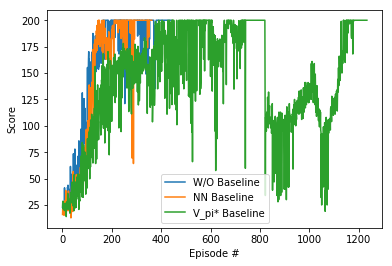

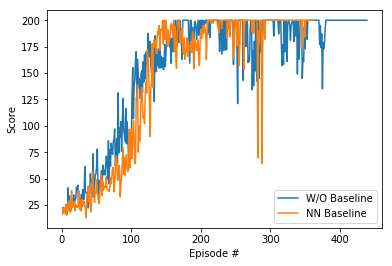

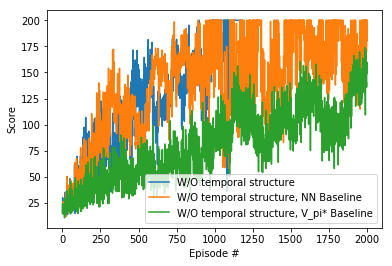

In [6]:
plt.figure()
plt.plot(np.arange(1, len(scores_classic)+1), scores_classic, label='W/O Baseline')
plt.plot(np.arange(1, len(scores_nnbaseline)+1), scores_nnbaseline, label='NN Baseline')
plt.plot(np.arange(1, len(scores_pioptbaseline)+1), scores_pioptbaseline, label='V_pi* Baseline')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.figure()
plt.plot(np.arange(1, len(scores_classic)+1), scores_classic, label='W/O Baseline')
plt.plot(np.arange(1, len(scores_nnbaseline)+1), scores_nnbaseline, label='NN Baseline')
# plt.plot(np.arange(1, len(scores_pioptbaseline)+1), scores_pioptbaseline, label='V_pi* Baseline')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.figure()
plt.plot(np.arange(1, len(scores_wots)+1), scores_wots, label='W/O temporal structure')
plt.plot(np.arange(1, len(scores_wots_nnbaseline)+1), scores_wots_nnbaseline, label='W/O temporal structure, NN Baseline')
plt.plot(np.arange(1, len(scores_wots_pioptbaseline)+1), scores_wots_pioptbaseline, label='W/O temporal structure, V_pi* Baseline')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [7]:
def plot_window(rtotal,k,l):
    k_window = np.zeros(len(rtotal) - k + 1)
    k_window[0] = np.mean(rtotal[:k])
    nums = len(rtotal)
    for i in range(k, nums):
        k_window[i+ 1 - k] =(rtotal[i] - rtotal[i-k+1]) / k + k_window[i-k] 
    plt.plot(range(len(rtotal) - k +1),k_window,label=l )

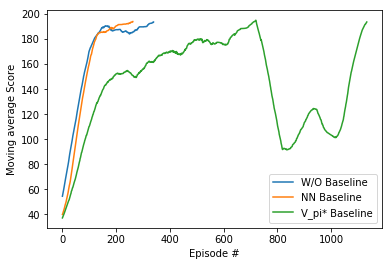

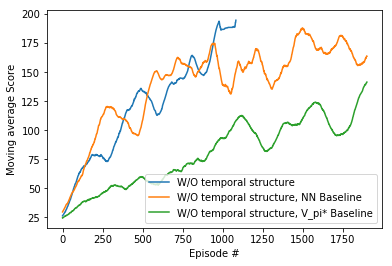

In [8]:
plt.figure()
plot_window(scores_classic, 100, l='W/O Baseline')
plot_window(scores_nnbaseline, 100, l='NN Baseline')
plot_window(scores_pioptbaseline, 100, l='V_pi* Baseline')
plt.ylabel('Moving average Score')
plt.xlabel('Episode #')
plt.legend()
plt.figure()
plot_window(scores_wots, 100, l='W/O temporal structure')
plot_window(scores_wots_nnbaseline, 100, l='W/O temporal structure, NN Baseline')
plot_window(scores_wots_pioptbaseline, 100, l='W/O temporal structure, V_pi* Baseline')
plt.ylabel('Moving average Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

### 5. Watch a Smart Agent!

In [12]:
env_to_wrap = gym.make('CartPole-v0')
env = wrappers.Monitor(env_to_wrap, './', force = True)

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()
env_to_wrap.close()